In [1]:
# !pip install pennylane nftopt

In [2]:
import cudaq
from cudaq import spin

cudaq.set_target("nvidia")

In [3]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from scipy import optimize
from nftopt import nakanishi_fujii_todo as nftmethod

In [4]:
#defining parameters
n_qubits = 15
depth = 4

In [5]:
import numpy as np
total_val = 2**n_qubits
arr = np.random.rand(1,total_val)
print(arr)

[[0.37119004 0.1961633  0.81616498 ... 0.43475222 0.11775007 0.25598085]]


In [6]:
summer = np.sum(arr)
print(summer)
normalized_X = arr/summer
print(normalized_X)

16355.126946902354
[[2.26956378e-05 1.19939942e-05 4.99026995e-05 ... 2.65820147e-05
  7.19958180e-06 1.56514131e-05]]


In [7]:
temp = []
for i in range(len(normalized_X[0])):
  temp.append(np.sqrt(normalized_X[0][i]))
x = np.array(temp)
print(x)

[0.00476399 0.00346323 0.00706418 ... 0.00515577 0.0026832  0.00395619]


In [8]:
sum = 0
for i in range(len(x)):
  sum += x[i]**2
print(sum)

0.9999999999999929


In [9]:
qubit_count = n_qubits

# Initialize a kernel/ ansatz and variational parameters.
kernel, parameters = cudaq.make_kernel(list)

# Allocate qubits that are initialised to the |0> state.
qubits = kernel.qalloc(qubit_count)


for dep in range(depth):
    for wire in range(n_qubits):
        kernel.ry(parameters[wire+(n_qubits*dep)], qubits[wire])

    for i in range(n_qubits-1):
        kernel.cz(control=qubits[i], target=qubits[i+1])
    
    kernel.cz(control=qubits[n_qubits-1], target=qubits[0])

# Initial gate parameters which intialize the qubit in the zero state
initial_parameters = 4*np.pi*np.random.rand(n_qubits * depth)

In [10]:
def accuracy(labels, predictions):
  state0 = qml.math.dm_from_state_vector(labels)
  state1 = qml.math.dm_from_state_vector(predictions)
  return qml.math.fidelity(state0, state1)

In [11]:
def F1_loss(a,Appro_a):
  #   Define the cost function
  F1 = 0.
  length = 2**n_qubits
  for i in range(length):
    F1 += (a[i]**2)*np.log2((Appro_a[i]**2)/(a[i]**2))
      
  #   Prepare the Bell state
  states = 2**n_qubits
  Bell_State=np.ones((states,1))/np.linalg.norm(np.ones((states,1)))
  #   The sum of vector a
  Sum_a=np.sum(a)
  sqrt_D = np.linalg.norm(np.ones((states,1)))
  UaFunction=np.abs(Sum_a -  (sqrt_D * np.matmul(np.transpose(Bell_State), Appro_a)))-(F1)
  return np.real(UaFunction)

In [12]:
cost_values = []
def cost(parameters):
    # X is our preparation state
    # Appro_a = variational_classifier(weights, x)
    Appro_a = cudaq.get_state(kernel,parameters)
    #result.dump()
    expectation_value = F1_loss(x, Appro_a)
    cost_values.append(expectation_value)
    return expectation_value

In [13]:
import time
start = time.time()
result= optimize.minimize(cost,initial_parameters, method=nftmethod, options={'maxfev':8000})
stop = time.time()
print(f"Training time: {stop - start}s")

Training time: 1077.2926959991455s


In [14]:
result.x

array([ 1.47513004e+01,  1.09940159e+01,  9.42487420e+00,  9.14846096e+00,
        9.42855597e+00,  3.76067838e+00,  9.42180277e+00,  3.25857934e+00,
        4.73579781e+00, -3.75943405e-04,  8.28034132e+00,  9.42441881e+00,
        1.49851568e-02,  6.51698128e+00,  9.42504510e+00,  6.28337390e+00,
        1.09955231e+01,  6.28267341e+00,  9.71018789e+00,  1.09922408e+01,
        1.32952544e+01,  1.09975439e+01,  3.08233531e+00,  1.10554941e+01,
       -2.78603271e-04,  3.13015606e+00,  6.27514364e+00,  4.71958150e+00,
        6.47565222e+00,  1.57050898e+00,  1.09954806e+01,  7.85563986e+00,
        7.85309618e+00,  1.56959804e+00,  3.14408098e+00,  1.57046228e+00,
        6.28137395e+00,  4.71215349e+00,  1.41349996e+01,  4.71294083e+00,
       -4.38259557e-01,  7.85407456e+00,  3.13374590e+00,  1.41369941e+01,
        1.25661543e+01,  2.18572036e+00,  1.25665718e+01,  1.75197345e-04,
        9.42492459e+00,  3.14158366e+00,  7.62893617e+00,  1.25661744e+01,
        9.30189416e+00,  

In [15]:
np.savetxt('15_qubit_data.out', x, delimiter=',')   # X is an array

In [16]:
value = np.loadtxt('15_qubit_data.out')
print(value)

[0.00476399 0.00346323 0.00706418 ... 0.00515577 0.0026832  0.00395619]


In [17]:
np.savetxt('15_qubit_weights.out', result.x, delimiter=',')   # weights is an array

In [18]:
weights = np.loadtxt('15_qubit_weights.out')
print(weights)

[ 1.47513004e+01  1.09940159e+01  9.42487420e+00  9.14846096e+00
  9.42855597e+00  3.76067838e+00  9.42180277e+00  3.25857934e+00
  4.73579781e+00 -3.75943405e-04  8.28034132e+00  9.42441881e+00
  1.49851568e-02  6.51698128e+00  9.42504510e+00  6.28337390e+00
  1.09955231e+01  6.28267341e+00  9.71018789e+00  1.09922408e+01
  1.32952544e+01  1.09975439e+01  3.08233531e+00  1.10554941e+01
 -2.78603271e-04  3.13015606e+00  6.27514364e+00  4.71958150e+00
  6.47565222e+00  1.57050898e+00  1.09954806e+01  7.85563986e+00
  7.85309618e+00  1.56959804e+00  3.14408098e+00  1.57046228e+00
  6.28137395e+00  4.71215349e+00  1.41349996e+01  4.71294083e+00
 -4.38259557e-01  7.85407456e+00  3.13374590e+00  1.41369941e+01
  1.25661543e+01  2.18572036e+00  1.25665718e+01  1.75197345e-04
  9.42492459e+00  3.14158366e+00  7.62893617e+00  1.25661744e+01
  9.30189416e+00  1.96086969e-04  9.42457525e+00  6.28318949e+00
  6.27709236e+00  9.42599107e+00  6.24480477e+00  3.14090845e+00]


In [19]:
# Fails because of large density matrix comutation for estimating fidelity
# # predictions=variational_classifier(result.x,x)
# predictions = np.array(cudaq.get_state(kernel,weights))
# predictions_arr = []
# for i in range(len(predictions)):
#     predictions_arr.append(predictions[i].numpy())
# acc = accuracy(value, predictions_arr)
# # print(predictions.numpy(), x.numpy())
# # print(acc)

In [20]:
plotting_values = []
for i in range(len(cost_values)):
    val = cost_values[i].tolist()
    plotting_values.append(val)

Text(0, 0.5, 'Cost Value')

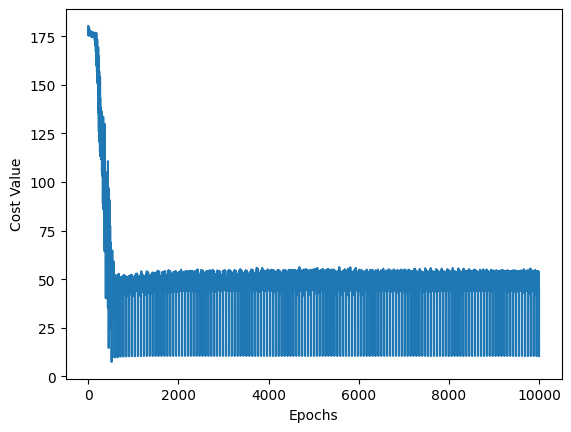

In [21]:
# Plotting how the value of the cost function decreases during the minimization procedure.
import matplotlib.pyplot as plt

x_values = list(range(len(plotting_values)))
y_values = plotting_values

plt.plot(x_values, y_values)

plt.xlabel("Epochs")
plt.ylabel("Cost Value")

In [22]:
result

 success: True
     fun: [ 1.047e+01]
       x: [ 1.475e+01  1.099e+01 ...  6.245e+00  3.141e+00]
     nit: 4922
    nfev: 10000